# Clustering Lab

 
Based of the amazing work you did in the Movie Industry you've been recruited to the NBA! You are working as the VP of Analytics that helps support a head scout, Mr. Rooney, for the worst team in the NBA probably the Wizards. Mr. Rooney just heard about Data Science and thinks it can solve all the team's problems!!! He wants you to figure out a way to find players that are high performing but maybe not highly paid that you can steal to get the team to the playoffs!

In this document you will work through a similar process that we did in class with the NBA data (NBA_Perf_22 and nba_salaries_22), merging them together. This is from 22-23 season, feel free to update to 2023-24 season if you want.
Data Sources:
https://www.basketball-reference.com/leagues/NBA_2024_totals.html # reference for performance data https://www.basketball-reference.com/contracts/players.html # reference for salary data

Details:

Determine a way to use clustering to estimate based on performance if players are under or over paid, generally.

Then select players you believe would be best for your team and explain why. Do so in three categories:

Examples that are not good choices (3 or 4)
Several options that are good choices (3 or 4)
Several options that could work, assuming you can't get the players in the good category (3 or 4)
You will decide the cutoffs for each category, so you should be able to explain why you chose them.

Provide a well commented and clean report of your findings in a separate notebook that can be presented to Mr. Rooney, keeping in mind he doesn't understand...anything. Include a rationale for variables you included in the model, details on your approach and a overview of the results with supporting visualizations.

Hints:

Salary is the variable you are trying to understand (not to predict, just understand)
When interpreting you might want to use graphs that include variables that are the most correlated with Salary
You'll need to scale the variables before performing the clustering
Be specific about why you selected the players that you did, more detail is better
Use good coding practices, comment heavily, indent, don't use for loops unless totally necessary and create modular sections that align with some outcome. If necessary create more than one script,list/load libraries at the top and don't include libraries that aren't used.
Be careful for non-traditional characters in the players names, certain graphs won't work when these characters are included.

choose something that best shows salary, 
because there are so many basketball players names, you. might want to encode them (encoding=latin)

In [30]:
import os
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix

In [31]:
perf_df = pd.read_csv("/workspaces/DS-3021/data/nba_perf_22.csv", encoding = "latin")
nba_salaries_df = pd.read_csv("/workspaces/DS-3021/data/nba_salaries_22.csv", encoding = "latin")
perf_df.head()
nba_salaries_df.head()

,ï»¿Player,Salary
0,Stephen Curry,"$48,070,014"
1,Russell Westbrook,"$47,063,478"
2,LeBron James,"$44,474,988"
3,Kevin Durant,"$44,119,845"
4,Bradley Beal,"$43,279,250"


# Drop variables that will not be needed or are duplicates

##### clean salaries

In [32]:
# Load salary data
nba_salary_df = pd.read_csv("../data/nba_salaries_22.csv")

# Remove $ and commas, convert to numeric
nba_salary_df['Salary'] = nba_salary_df['Salary'].replace('[\$,]', '', regex=True).astype(float)

# Strip whitespace from names
nba_salary_df['Player'] = nba_salary_df['Player'].str.strip()

# Preview
nba_salary_df.head()


<>:5: SyntaxWarning:

invalid escape sequence '\$'

<>:5: SyntaxWarning:

invalid escape sequence '\$'

/tmp/ipykernel_2482/1902133927.py:5: SyntaxWarning:

invalid escape sequence '\$'



,Player,Salary
0,Stephen Curry,48070014.0
1,Russell Westbrook,47063478.0
2,LeBron James,44474988.0
3,Kevin Durant,44119845.0
4,Bradley Beal,43279250.0


#### clean performance data

In [ ]:
# Strip whitespace from names and fix encoding
perf_df['Player'] = perf_df['Player'].str.strip()

# Optional: Normalize player names (remove special chars)
perf_df['Player'] = perf_df['Player'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')


# Select only key numeric features + Player
selected_columns = ['Player', 'PTS', 'AST', 'FG','TRB', 'STL', 'BLK', 'TOV', 'G', 'MP']
perf_df = perf_df[selected_columns]

# Drop rows with missing or weird data
perf_df.dropna(inplace=True)

# Preview
perf_df.head()


,Player,PTS,AST,FG,TRB,STL,BLK,TOV,G,MP
0,Precious Achiuwa,9.1,1.1,3.6,6.5,0.5,0.6,1.2,73,23.6
1,Steven Adams,6.9,3.4,2.8,10.0,0.9,0.8,1.5,76,26.3
2,Bam Adebayo,19.1,3.4,7.3,10.1,1.4,0.8,2.6,56,32.6
3,Santi Aldama,4.1,0.7,1.7,2.7,0.2,0.3,0.5,32,11.3
4,LaMarcus Aldridge,12.9,0.9,5.4,5.5,0.3,1.0,0.9,47,22.3


# drop unnecessary columns, for example the repeated information liek percentage and stuff

#### merge 2 datasets

In [34]:
# Merge on player name
df = pd.merge(perf_df, nba_salary_df, on='Player', how='inner')
# Final cleanup: drop missing values, reset index
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

# Preview merged data
df.head()


,Player,PTS,AST,FG,TRB,STL,BLK,TOV,G,MP,Salary
0,Precious Achiuwa,9.1,1.1,3.6,6.5,0.5,0.6,1.2,73,23.6,2840160.0
1,Steven Adams,6.9,3.4,2.8,10.0,0.9,0.8,1.5,76,26.3,17926829.0
2,Bam Adebayo,19.1,3.4,7.3,10.1,1.4,0.8,2.6,56,32.6,30351780.0
3,Santi Aldama,4.1,0.7,1.7,2.7,0.2,0.3,0.5,32,11.3,2094120.0
4,Nickeil Alexander-Walker,10.6,2.4,3.9,2.9,0.7,0.4,1.4,65,22.6,5009633.0


# Run the clustering algo with your best guess for K

In [44]:
# Group by 'Cluster' and calculate the mean for selected columns
df.groupby('Cluster')[['PTS', 'FG', 'AST', 'TRB', 'Salary']].mean()

,PTS,FG,AST,TRB,Salary
Cluster,,,,,
0,16.632934,6.052695,4.057485,5.677844,1.881342e+07
1,6.535714,2.427381,1.300595,3.164583,4.528126e+06


In [46]:
from sklearn.preprocessing import StandardScaler

#cluster 0: high salary, high performance
#cluster 1: high performance, low salary
# Select features to cluster on (can be customized)
features = ['PTS', 'AST', 'TRB', 'FG','STL', 'BLK', 'TOV', 'G', 'MP', 'Salary']

# Scale the features so all have equal weight
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features])

# Run KMeans with your best guess k=2
k = 2
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
kmeans.fit(X_scaled)

# Add cluster labels back to original dataframe
df['Cluster'] = kmeans.labels_

# Preview results
df[['Player', 'Salary', 'Cluster'] + features].head()


,Player,Salary,Cluster,PTS,AST,TRB,FG,STL,BLK,TOV,G,MP,Salary
0,Precious Achiuwa,2840160.0,1,9.1,1.1,6.5,3.6,0.5,0.6,1.2,73,23.6,2840160.0
1,Steven Adams,17926829.0,0,6.9,3.4,10.0,2.8,0.9,0.8,1.5,76,26.3,17926829.0
2,Bam Adebayo,30351780.0,0,19.1,3.4,10.1,7.3,1.4,0.8,2.6,56,32.6,30351780.0
3,Santi Aldama,2094120.0,1,4.1,0.7,2.7,1.7,0.2,0.3,0.5,32,11.3,2094120.0
4,Nickeil Alexander-Walker,5009633.0,1,10.6,2.4,2.9,3.9,0.7,0.4,1.4,65,22.6,5009633.0


In [49]:
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
kmeans.fit(X_scaled)


KMeans(n_clusters=2, n_init=10, random_state=42)

# View the results

In [50]:
# Print cluster centers (in scaled feature space)
print("Cluster centers:\n", kmeans.cluster_centers_)

# Print cluster labels for each player
print("Cluster labels:\n", kmeans.labels_)

# Print total within-cluster sum of squares (inertia)
print("Inertia (total WCSS):", kmeans.inertia_)


Cluster centers:
 [[ 1.09833837  0.94032964  0.73122251  1.10016846  0.82519316  0.38299487
   1.02950083  0.40762171  1.06624868  0.95533283]
 [-0.54590032 -0.46736622 -0.363435   -0.54680992 -0.41014065 -0.19035757
  -0.51168643 -0.2025977  -0.52995098 -0.47482317]]
Cluster labels:
 [1 0 0 1 1 0 1 1 0 1 1 0 1 0 0 1 1 1 1 1 0 1 1 1 0 0 0 0 0 1 0 0 0 0 1 1 1
 1 0 0 1 0 0 1 1 1 0 1 1 0 1 1 1 1 0 1 0 0 1 1 0 1 1 0 1 1 0 1 0 0 1 0 1 1
 1 1 1 1 1 1 1 0 0 1 1 1 1 0 1 1 0 1 0 1 0 0 1 1 1 1 0 0 0 0 0 0 0 1 1 1 0
 1 1 0 0 0 1 1 0 0 1 0 1 0 0 0 0 1 0 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 0 0 0 1
 1 1 1 1 1 1 0 1 1 0 1 0 0 1 0 0 0 0 0 1 0 0 1 1 1 1 1 1 1 1 0 0 0 1 0 0 0
 0 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1
 0 1 1 1 1 1 1 1 0 0 1 0 1 1 1 0 0 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 0 0 0 1 0 1 1 1 1
 1 1 1 1 0 0 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 0 0 0 1 1 1 1 1 1 1 0 1 1 0
 1 1 0 0 0 0 1 0 1 1 1 0 1 0 1 0 1 1 1 

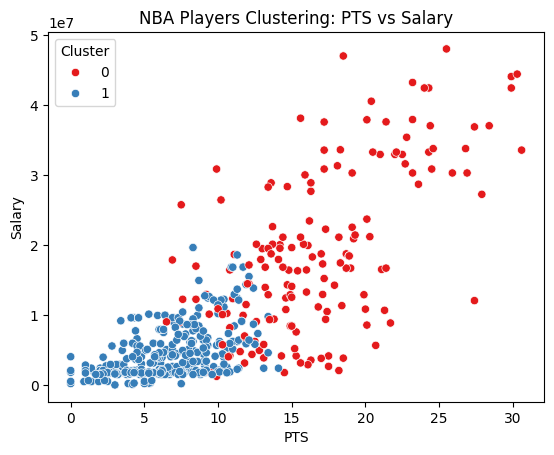

In [38]:
# See how many players are in each cluster
df['Cluster'].value_counts()
# Look at average performance and salary per cluster
df.groupby('Cluster')[['PTS', 'AST', 'TRB', 'STL', 'BLK', 'TOV', 'G', 'MP', 'Salary']].mean()
# Sort by salary within each cluster to identify hidden gems
df.sort_values(['Cluster', 'Salary']).head(10)
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(data=df, x='PTS', y='Salary', hue='Cluster', palette='Set1')
plt.title('NBA Players Clustering: PTS vs Salary')
plt.show()


In [47]:
# Select numeric features
correlation_df = df[['Salary', 'PTS', 'AST', 'FG','TRB', 'STL', 'BLK', 'TOV', 'G', 'MP']]

# Calculate correlation matrix
correlation_matrix = correlation_df.corr()

# Display
correlation_matrix['Salary'].sort_values(ascending=False)


Salary    1.000000
PTS       0.784472
FG        0.770245
TOV       0.682251
MP        0.676218
AST       0.615907
TRB       0.495766
STL       0.469915
BLK       0.272589
G         0.230218
Name: Salary, dtype: float64

# Create a visualization of the results with 2 or 3 variables that you think will best differentiate the clusters

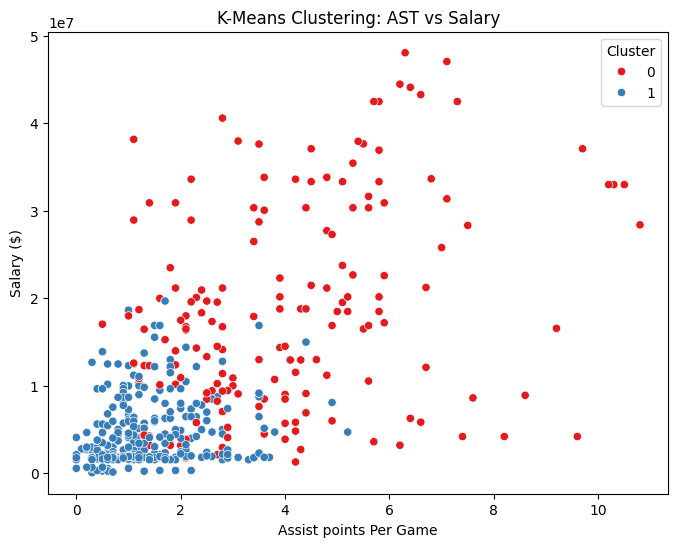

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='AST', y='Salary', hue='Cluster', palette='Set1')
plt.title('K-Means Clustering: AST vs Salary')
plt.xlabel('Assist points Per Game')
plt.ylabel('Salary ($)')
plt.legend(title='Cluster')
plt.show()


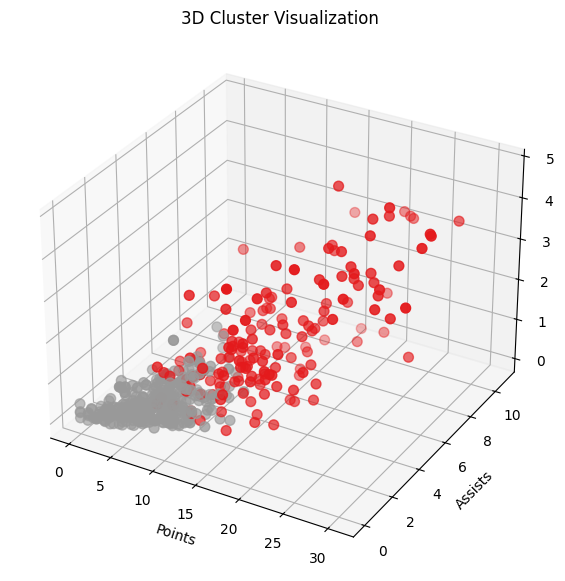

In [20]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df['PTS'], df['AST'], df['Salary'], c=df['Cluster'], cmap='Set1', s=50)
ax.set_xlabel('Points')
ax.set_ylabel('Assists')
ax.set_zlabel('Salary')
ax.set_title('3D Cluster Visualization')

plt.show()


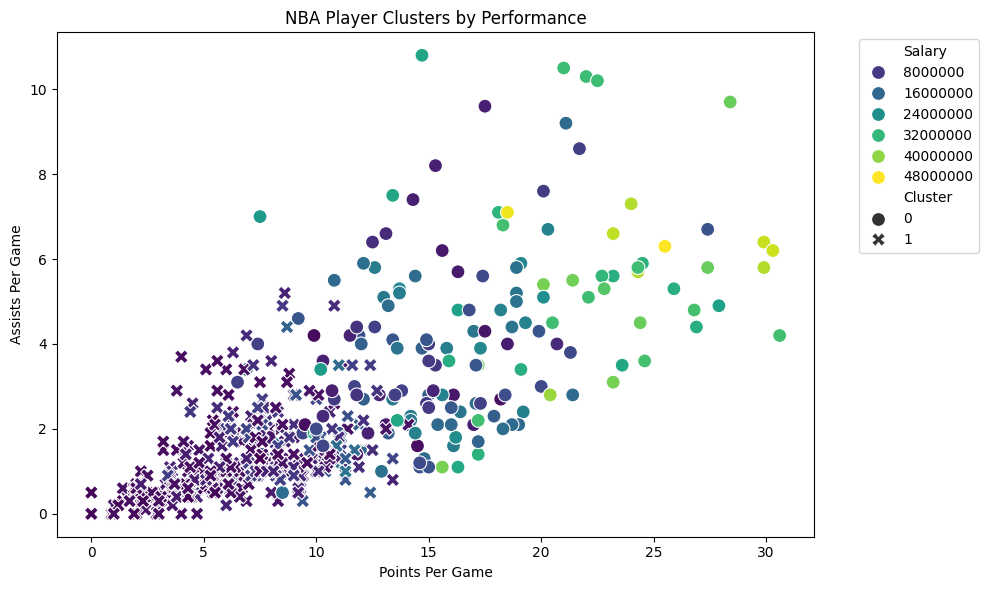

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a scatterplot with:
# - X-axis: Points
# - Y-axis: Assists
# - Hue: Salary (color gradient)
# - Style: Cluster (marker shape)
plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(
    data=df,
    x='PTS', 
    y='AST',
    hue='Salary',          # color based on salary
    style='Cluster',       # shape based on cluster
    palette='viridis',     # color gradient
    s=100                  # marker size
)

plt.title("NBA Player Clusters by Performance")
plt.xlabel("Points Per Game")
plt.ylabel("Assists Per Game")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


# do this in 3d, so we can see who the players are

# Evaluate the quality of the clustering using total variance explained and silhouette scores

In [41]:
# Inertia (Total Within-Cluster Sum of Squares)
print(f"Total Within-Cluster Sum of Squares (Inertia): {kmeans.inertia_:.2f}")


Total Within-Cluster Sum of Squares (Inertia): 3045.27


In [43]:
from sklearn.metrics import silhouette_score

# Silhouette score (higher is better)
sil_score = silhouette_score(X_scaled, kmeans.labels_)
print(f"Silhouette Score: {sil_score:.3f}")


Silhouette Score: 0.368


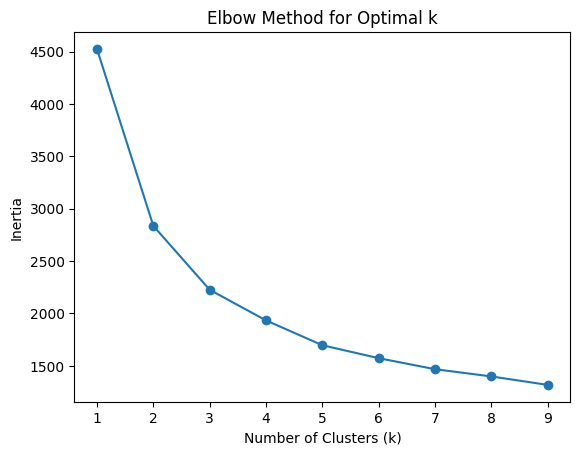

In [25]:
inertias = []
for k in range(1, 10):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    inertias.append(km.inertia_)

plt.plot(range(1, 10), inertias, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()


# Determine the ideal number of clusters using the elbow method and the silhouette coefficient

# Visualize the results of the elbow method

# Use the recommended number of cluster (assuming it's different) to retrain your model and visualize the results

# Once again evaluate the quality of the clustering using total variance explained and silhouette scores

# Use the model to select players for Mr. Rooney to consider

# Write up the results in a separate notebook with supporting visualizations and an overview of how and why you made the choices you did. This should be at least 500 words and should be written for a non-technical audience.